## Busted! - Finding Patterns to Detect AI Generated Content in Essays
## A project by Noel McCann
<img src="Images/pexels-katerina-holmes-5905885.jpg" style="width:640px;height:360px;">

**Purpose of Analysis:** 
Since ChatGPT's public release on November 30, 2022, the use of LLMs has become commonplace. Writers and content creators alike rely on LLMs to develop anything from videos and images to scripts and story ideas. From drafting an outline for an essay to planning out a tailgating menu for Super Bowl Sunday, the answers people look for are can be found by sharing a well-written prompt with a tool such as ChatGPT or Bard.

However, with the ability to create new content within seconds comes great responsibility. Some students and writers view LLMs as a shortcut, with many using AI to write their essays and books. In response to the rise of AI-generated content on the Kindle, [Amazon capped e-book publications to 3](https://arstechnica.com/information-technology/2023/09/ai-generated-books-force-amazon-to-cap-ebook-publications-to-3-per-day/). Moreover, 75% of students in a Turnitin survey said they'd continue using AI, [leading schools such as Pepperdine to introduce tools that can identify AI-generated content](https://www.foxbusiness.com/technology/universities-consider-academic-integrity-approach-evolving-ai-filled-future).

With the increased risk of students abusing chatbots and AI tools to cut corners on essays, detecting AI-generated content has become especially important. For today's project, we will utilize BERT (Bidirectional Encoder Representations from Transformers) to predict which essays are actually written by a human.

## Data Importing & Cleaning
Let's get started by getting our libraries 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Exploratory Data Analysis

With everything we need to run our analysis, let's take a look into the training and test essay CSVs to see what we have available. 

In [11]:
# Define file paths
train_essays_path = 'train_essays.csv'
test_essays_path = 'test_essays.csv'
train_prompts_path = 'train_prompts.csv'

# Load the data
train_essays_df = pd.read_csv(train_essays_path)
test_essays_df = pd.read_csv(test_essays_path)
train_prompts_df = pd.read_csv(train_prompts_path)

In [15]:
# Display the few rows of the training essays
train_essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


The `train_essays.csv` file contains the following columns:

1. **id**: The unique identifier for each essay.
2. **prompt_id**: The unique identifier for each essay's prompt.
3. **text**: The text of the essay shared.
4. **generated**: Boolean that determines whether the text was generated by AI or written by a human.

In [16]:
# Display the few rows of the test essays
test_essays_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


The `test_essays.csv` file contains the following columns:

1. **id**: The unique identifier for each essay.
2. **prompt_id**: The unique identifier for each essay's prompt.
3. **text**: The text of the essay shared.

**Notice that the test CSV does not have a boolean flag for AI-generated content.**

In [17]:
# Display the few rows of the training prompts used for essays
train_prompts_df.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


The `train_prompts.csv` file contains the following columns:

1. **prompt_id**: The unique identifier for each essay's prompt.
2. **prompt_name**: The unique prompt's summary title.
3. **instructions**: The instructions for the chatbot/AI tool in the essay.
4. **source_text**: The sourced essay from `train_essays`

With the summaries out of the way, let's check the data quality.

In [18]:
# Check for missing values in the datasets
missing_values_train = train_essays_df.isnull().sum()
print("missing_values_train:", missing_values_train)
missing_values_test = test_essays_df.isnull().sum()
print("\nmissing_values_train:", missing_values_train)
missing_values_prompts = train_prompts_df.isnull().sum()
print("\nmissing_values_prompts:", missing_values_prompts)

missing_values_train: id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_train: id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_prompts: prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


The datasets are clean and do not have any missing values. Even with the data being clean, it is important to look into the balance of the dataset. An imbalanced dataset can impact the performance of predictive models.

So what is the balance between essays written by students and those generated by LLMs in the training set?

In [19]:
# Distribution of the 'generated' column
train_essays_df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

With only 3 essays with the boolean set to 1, we are working with a highly imbalanced dataset that is overwhelmingly filled with human-written essays. Splitting the dataset will still retain the bias, so we'll need to pivot to make the most of this imbalanced data.

### Length & Keyword Analysis

Given we have just 3 essays that are AI-generated, we'll need to figure out a different strategy to analyze the differences between AI-generated and human-written essays. Given LLMs tend to be limited in word count, we can instead look into the length of the essays to determine differences between essays from LLMs and from actual students.

We will calculate the length of each essay and compare the distributions between the two categories.

#### Average Essay Length

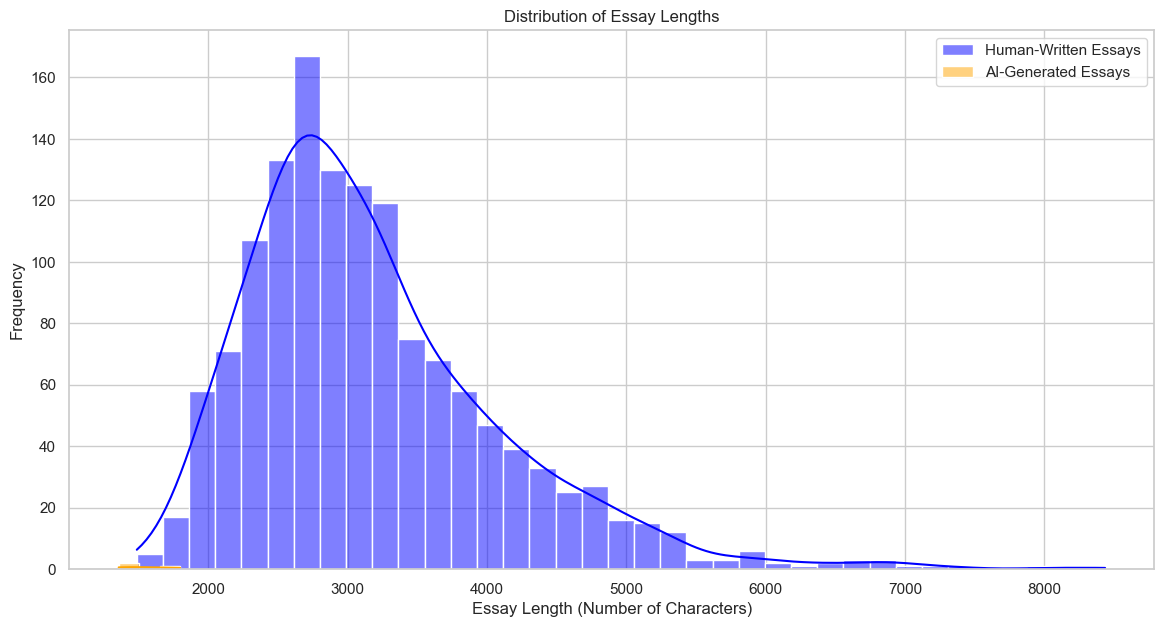

In [20]:
# Calculate the length of each essay
train_essays_df['essay_length'] = train_essays_df['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Distribution of essay lengths for human-written essays
sns.histplot(train_essays_df[train_essays_df['generated'] == 0]['essay_length'], color="blue", label='Human-Written Essays', kde=True)

# Distribution of essay lengths for LLM-generated essays
sns.histplot(train_essays_df[train_essays_df['generated'] == 1]['essay_length'], color="orange", label='AI-Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The histogram leans to the left, with most human-written essays ranging between 2,000 to 3,000 characters. Let's get a clearer picture of the length differences between essays from AI and essays from actual humans.

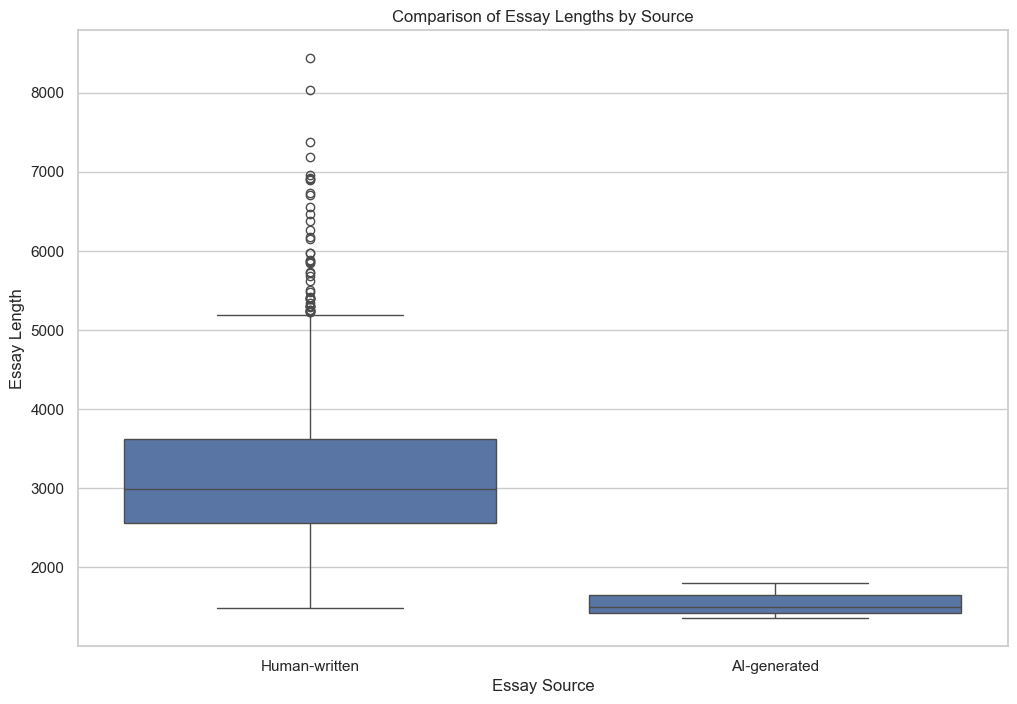

In [23]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='generated', y='essay_length', data=train_essays_df)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Human-written', 'AI-generated'])
plt.show()

In [36]:
def calculate_text_metrics_simple(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length

# Apply the function to the 'text' column
train_essays_df['metrics'] = train_essays_df['text'].apply(calculate_text_metrics_simple)

# Expand the 'metrics' column into separate columns
train_essays_df[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']] = pd.DataFrame(train_essays_df['metrics'].tolist(), index=train_essays_df.index)

# Drop the 'metrics' column
train_essays_df.drop('metrics', axis=1, inplace=True)

# Group by 'generated' to compare these metrics between human-written and AI-generated essays
comparison_metrics = train_essays_df.groupby('generated')[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']].mean()



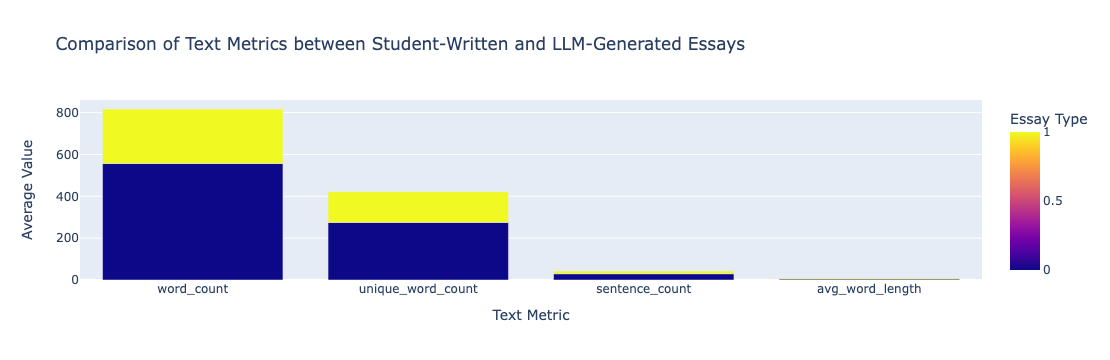

In [37]:
import plotly.express as px

comparison_metrics_reset = comparison_metrics.reset_index()

comparison_long = comparison_metrics_reset.melt(id_vars='generated', var_name='Metric', value_name='Value')

custom_colors = px.colors.qualitative.Pastel

fig = px.bar(
    comparison_long,
    x='Metric',
    y='Value',
    color='generated',
    barmode='group',
    title='Comparison of Text Metrics between Student-Written and LLM-Generated Essays',
    labels={'generated': 'Essay Type', 'Value': 'Average Value'},
    color_discrete_sequence=custom_colors  
)

fig.update_layout(
    xaxis_title='Text Metric',
    yaxis_title='Average Value',
    legend_title='Essay Type'
)

# Display the figure
fig.show()


While there is the caveat of a dearth of AI-generated examples, some clear giveaways for AI-generated essays are beginning to emerge. On average, AI-generated essays have a sentence count of 13 and a word count of 260 words, 146 of which are unique. The box plot for AI-generated content also doesn't exceed 2000 characters.

In sharp contrast, human-written essays have a sentence count of 13 and a word count of 557, 275 of which are unique. Human-written essays are significantly longer and utilize additional unique words. This is just a start, but shorter essays could be the first sign that an essay was generated by an AI than actually written. 

#### Common words used

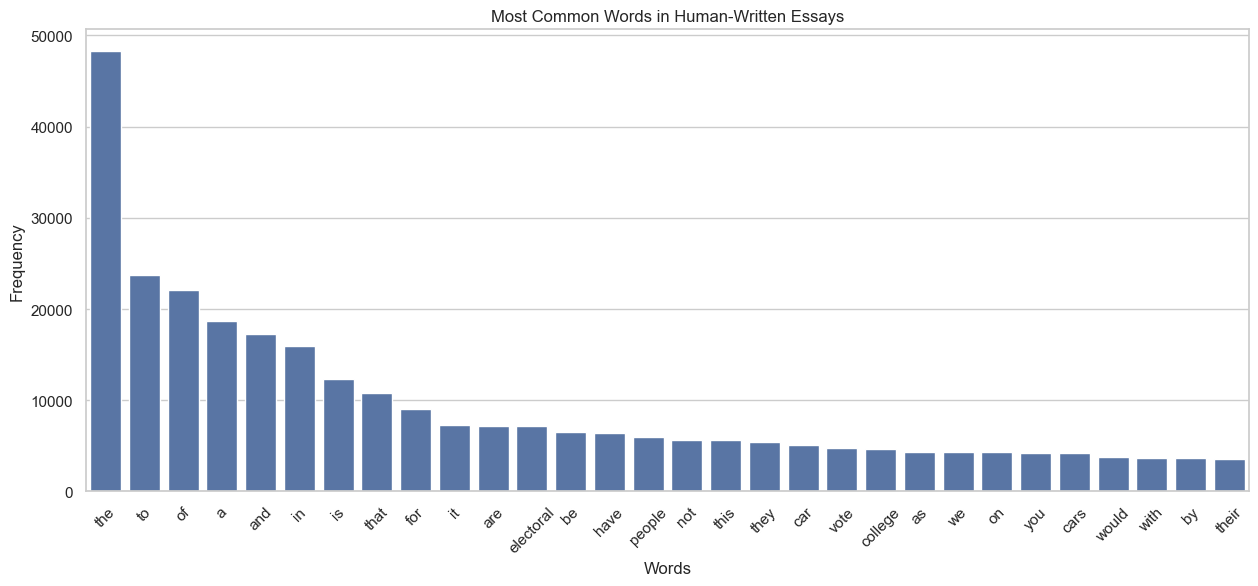

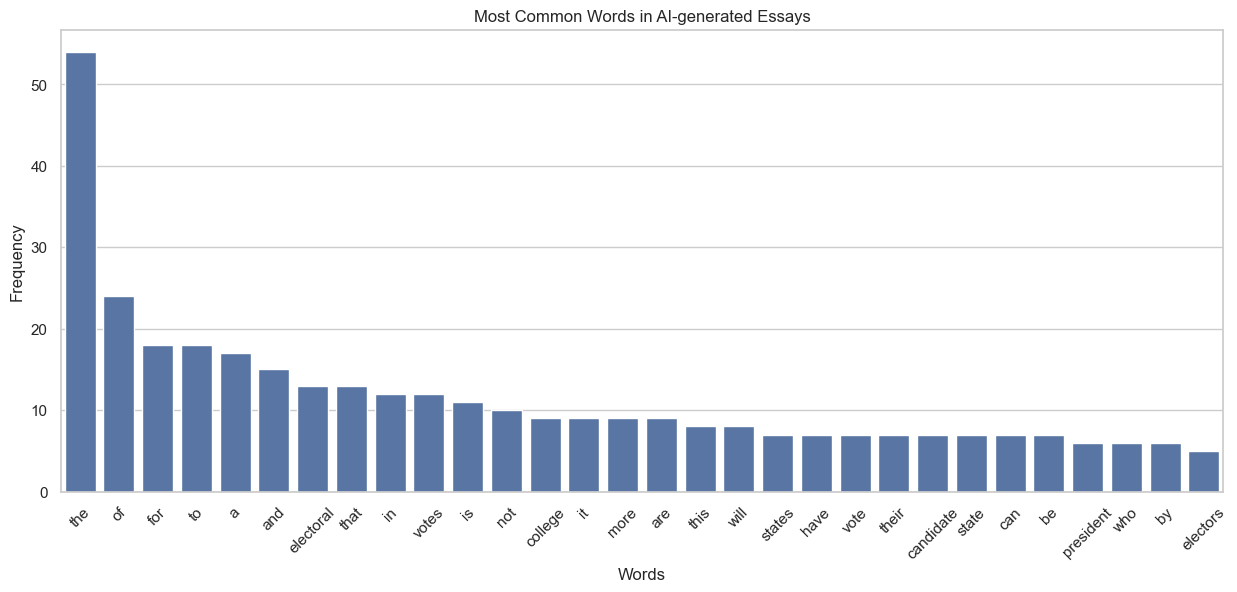

In [38]:
from collections import Counter
import itertools

def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)
    
    # Plot the most common words
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

plot_most_common_words(train_essays_df[train_essays_df['generated'] == 0]['text'], title="Most Common Words in Human-Written Essays")
plot_most_common_words(train_essays_df[train_essays_df['generated'] == 1]['text'], title="Most Common Words in AI-generated Essays")

Using a prompt for an essay on US politics and the Electoral College, we can see that common words in human-written essays differ from those in AI-generated essays. AI-generated essays utilize electoral, votes, and college amongst other keywords that differ from that of human-written essays. But why? Let's take a look at the relationship between the prompt and the essay.

#### The Relationship Between Prompt and Essay

Let's take a closer look at the association between the training prompts and the training essays. Using `train_prompts_df` and `train_essays_df`, we will explore the frequency of prompt usage, the average length of essays per prompt, and thematic connections between the two.

In [40]:
train_prompts_ex = train_prompts_df.iloc[0]
#detailed look into the columns available
from IPython.display import display, Markdown

display(Markdown(f"### Prompt Name:\n{train_prompts_ex['prompt_name']}"))
display(Markdown("====="))
display(Markdown(f"### Instructions:\n{train_prompts_ex['instructions']}"))
display(Markdown("====="))
display(Markdown(f"### Source Text:\n (The text of the essays written)"))

### Prompt Name:
Car-free cities

=====

### Instructions:
Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.

=====

### Source Text:
 (The text of the essays written)

### Prompt Usage Frequency

prompt_id
0    708
1    670
Name: count, dtype: int64

### Average Essay Length by Prompt

prompt_id
0    3251.927966
1    3081.473134
Name: essay_length, dtype: float64

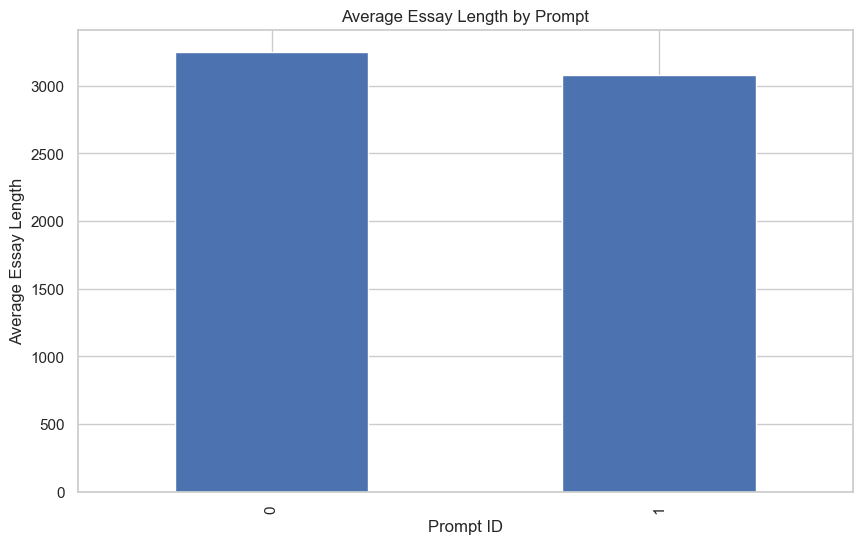

In [41]:
train_essays_df['essay_length'] = train_essays_df['text'].apply(len)

merged_df = train_essays_df.merge(train_prompts_df, on='prompt_id', how='left')

# Analyze prompt frequency
prompt_usage = merged_df['prompt_id'].value_counts()

# Average essay length by prompt
avg_length_by_prompt = merged_df.groupby('prompt_id')['essay_length'].mean()

# Display prompt frequency
display(Markdown("### Prompt Usage Frequency"))
display(prompt_usage)

# Display average essay length by prompt
display(Markdown("### Average Essay Length by Prompt"))
display(avg_length_by_prompt)

# Plot average essay length by prompt
plt.figure(figsize=(10, 6))
avg_length_by_prompt.plot(kind='bar')
plt.title('Average Essay Length by Prompt')
plt.xlabel('Prompt ID')
plt.ylabel('Average Essay Length')
plt.show()


top_words: [('electoral', 44), ('vote', 36), ('electors', 31), ('car', 28), ('college', 27), ('president', 25), ('state', 23), ('election', 21), ('votes', 20), ('cars', 19)]


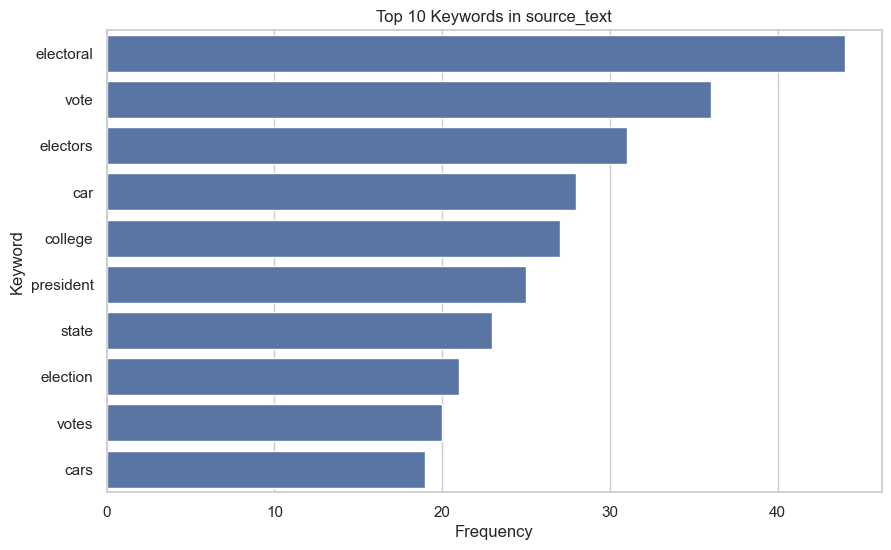


top_words: [('electoral', 7234), ('people', 6924), ('college', 6081), ('vote', 6000), ('car', 5888), ('cars', 5731), ('states', 4132), ('president', 3615), ('votes', 2536), ('electors', 2515)]


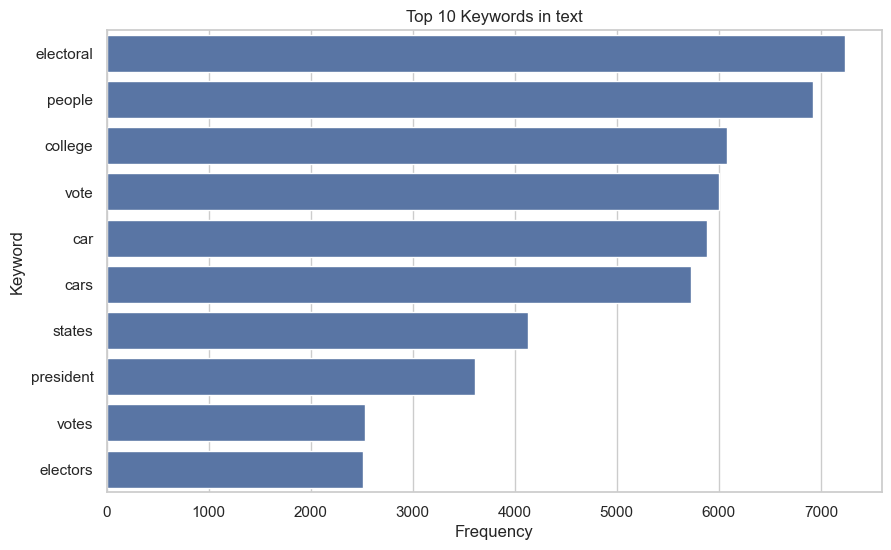

In [42]:
def plot_top_keywords(data, column, num_keywords=10):
    vec = CountVectorizer(stop_words='english').fit(data[column])
    bag_of_words = vec.transform(data[column])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words = words_freq[:num_keywords]
    print("\ntop_words:", top_words)
    # Convert to DataFrame
    top_df = pd.DataFrame(top_words, columns=['Keyword', 'Frequency'])
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x='Frequency', y='Keyword', data=top_df)
    plt.title(f'Top {num_keywords} Keywords in {column}')
    plt.show()

# Plot top keywords for prompts
plot_top_keywords(train_prompts_df, 'source_text')

# Plot top keywords for essays
plot_top_keywords(train_essays_df, 'text')

Upon looking into the source text and text, we can see that the prompt of the essay will heavily impact the words and keywords in the resultant essay written. Keywords such as 'electoral', 'college', 'vote', and 'president' are prominent in both, indicating that human writers stay close to the core topic highlighted in the prompt.

High-frequency keywords such as `electoral` (7234 appearances) and `people` (6924 appearances) suggest writers try to look into incorporating a societal context when tackling the importance of electoral colleges or other elements based on the political essay present.

Topic-related vocabulary in the essays would thus be helpful as a feature for models that are tasked to identify essays generated by AI. 

Next time in Part II, we will look into the coherence differences between human-written and AI-generated essays and cluster the results to get a better picture. Later, we will predict which essays were generated by AI via BERT, a sophisticated language processing model designed to understand the context of words in a sentence by analyzing text in both directions (left-to-right and right-to-left).
